In [3]:
import pandas as pd

pd.read_spss(r"E:\Honduras Census\2013\SPSS\BARRIO.sav")

,BARRIO_REF_ID,CASERIO_REF_ID,G09,NBARRIO,REDCODEC
0,1.0,1.0,001,BO. ALVARADO,010101001001
1,2.0,1.0,002,BO. BELLA VISTA,010101001002
2,3.0,1.0,003,COL. BRISAS DEL CANGREJAL,010101001003
3,4.0,1.0,004,BO. BUENOS AIRES,010101001004
4,5.0,1.0,005,BO. EL CENTRO,010101001005
...,...,...,...,...,...
35878,35879.0,30182.0,000,,181109005000
35879,35880.0,30183.0,000,,181109009000
35880,35881.0,30184.0,000,,181109011000
35881,35882.0,30185.0,000,,181109012000


In [ ]:
df = df[df.property_type.isin(['Casa','Departamento', 'Casa de campo', 'PH']) & (df.price>=10000) & (df.price<=1000000)]

In [ ]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))


<Axes: >

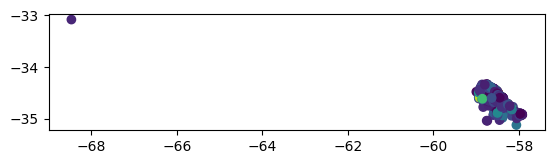

In [83]:
gdf = gdf[gdf.l2.isin(['Capital Federal', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Sur', 'Bs.As. G.B.A. Zona Oeste'])]
# Keep only valid geometries
gdf = gdf[gdf.geometry.is_valid & ~gdf.geometry.is_empty].set_crs(epsg=4326)
gdf.sample(1000).plot(column='price')

In [1]:
import run_model

ModuleNotFoundError: No module named 'run_model'

In [ ]:
import xarray as xr
ds = xr.open_dataset(r"D:\Downloads\bsose_i105_2008to2012_monthly_Mu.nc")

In [ ]:
import matplotlib.pyplot as plt
ds.sel(Z=-2.1, time=ds.time[0], XC=slice(250, 360))['BLGMU'].plot(figsize=(16, 10))
# plt.axis('off')

In [ ]:
try:
    from sfi import Macro

    root = Macro.getGlobal("root")
    data_raw = Macro.getGlobal("data_raw")
    data_processed = Macro.getGlobal("data_processed")
    data_output = Macro.getGlobal("data_output")
    excels = Macro.getGlobal("excels")
    date = Macro.getGlobal("date")  # Date when the full process is run
    extra = Macro.getGlobal(
        "extra"
    )  # Placeholder for testing, just add "_test" or something like that to avoid overwrite db

except:
    root = r"D:\Laboral\World Bank\Data-Portal-Brief-Generator"
    # portal = r"C:\Users\llohi\OneDrive - Universidad Torcuato Di Tella\WB\Data-Portal-Brief-Generator"
    data_raw = rf"{root}\Data\Data_Raw"
    data_processed = rf"{root}\Data\Data_Processed"
    data_output = rf"{root}\Data\Data_Output"
    extra = ""

sources = rf"{root}\Sources"
briefs = rf"{root}\Briefs"
excels = rf"{root}\Datasheets"

import os
import pandas as pd
from tqdm import tqdm
from PIL import Image
from pdf2image import convert_from_path


def list_files_in_directory(folder_path):
    file_list = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list


def resize_image(image, new_width):
    old_width = image.size[0]
    old_height = image.size[1]
    new_height = int(old_height * (new_width / old_width))
    return image.resize((new_width, new_height)), new_height


def add_header_and_footer(background, header, footer):
    # Resize the header and footer images to match the background size
    new_width = background.size[0] + 2
    header, new_height = resize_image(header, new_width)
    footer, new_height = resize_image(footer, new_width)

    # Create a new image with transparency
    merged_image = Image.new("RGB", background.size)

    # Paste the background image onto the new image
    merged_image.paste(background, (0, 0))

    # Paste the footer image onto the new image, using the alpha channel of the footer
    merged_image.paste(footer, (-1, background.size[1] - new_height + 2), mask=footer)
    merged_image.paste(header, (-1, -1), mask=header)

    return merged_image


df = pd.read_stata(rf"{data_output}\ordered_text.dta")
df = df.sort_values(by=["wbregion", "wbcode"])
# df = df[df.wbcode.isin(["AUT"])]
df = df[df.wbregion == "East Asia & Pacific"]

headers = list_files_in_directory(rf"{sources}\\Header Images\\Headers pngs")
images = {k: [] for k in df.wbregion.unique()}
for country_data in tqdm(df[["wbcode", "wbcountryname", "wbregion"]].itertuples()):
    try:
        wbcode = country_data[1]
        wbcountryname = country_data[2]
        wbregion = country_data[3]

        # print(wbcode)
        pdf = convert_from_path(
            rf"{briefs}\{wbcountryname}\{wbcountryname}{extra}.pdf",
            size=(1700 * 2.5, 2200 * 2.5),
        )  # This returns a list even for a 1 page pdf

        ## P1
        header_path = [header for header in headers if f"1-HCCB-{wbcode}" in header][0]
        header = Image.open(header_path)
        footer = Image.open(rf"{sources}\Footer Images\p1 footer.png")

        page_1 = add_header_and_footer(pdf[0], header, footer)

        ## P2
        header_path = [header for header in headers if f"2-HCCB-{wbcode}" in header][0]
        header = Image.open(header_path)
        footer = Image.open(rf"{sources}\Footer Images\p2 footer.png")

        page_2 = add_header_and_footer(pdf[1], header, footer)

        # Save them
        # page_1.save(
        #     rf"{briefs}\For print\{wbregion}\{wbcountryname}{extra}.pdf",
        #     "PDF",
        #     mode="RGBA",
        #     resolution=100.0,
        #     save_all=True,
        #     append_images=[page_2],
        # )
        images[wbregion] += [page_1, page_2]

    except Exception as exception:
        print(f"Error with {wbcode}: {exception}")

In [ ]:
%tensorboard

In [ ]:
for region, imgs in images.items():
    os.makedirs(rf"{briefs}\For print\{region}_", exist_ok=True)

    imgs[0].save(
        rf"{briefs}\For print\{region}_\{region}_{extra}.pdf",
        "PDF",
        mode="RGBA",
        resolution=100.0,
        save_all=True,
        append_images=imgs[1:],
    )
    imgs = []

### Indicators differences v6 vs v9

In [8]:
import pandas as pd

new_listing = pd.read_stata(r"D:\Laboral\World Bank\Data-Portal-Brief-Generator\Data\Data_Output\listing.dta")
old_listing = pd.read_stata(r"D:\Laboral\World Bank\Data-Portal-Brief-Generator\Data\Data_Output\listing_cortev6.dta")
new_data_briefs = pd.read_stata(r"D:\Laboral\World Bank\Data-Portal-Brief-Generator\Data\Data_Output\data_briefs.dta")
old_data_briefs = pd.read_stata(r"D:\Laboral\World Bank\Data-Portal-Brief-Generator\Data\Data_Output\data_briefs___corte_2015.dta")

In [13]:
dataset = {}

from tqdm import tqdm
import numpy as np

for wbcode in tqdm(new_data_briefs.wbcode.unique()):
    
    new_row = new_listing.loc[new_listing.wbcode==wbcode]    
    old_row = old_listing.loc[old_listing.wbcode==wbcode]
    country_data = {}
    for stage in range(1,5):
        for position in range(1,4):
            
            indicator = new_row[f'name_{stage}_{position}']
            name = new_row[f'lbl_{stage}_{position}'].values[0]

            ### New listing
            year_new = new_row[f'year_{stage}_{position}'].values[0]
            try:
                value_new = new_data_briefs.loc[(new_data_briefs.wbcode == wbcode), indicator].values[0][0]
            except:
                value_new = np.nan
                year_new = np.nan
            
            ### Previous value
            try:
                year_prev = new_data_briefs.loc[(new_data_briefs.wbcode == wbcode), f"{indicator.values[0]}_year_prev"].values[0]
                value_prev = new_data_briefs.loc[(new_data_briefs.wbcode == wbcode), f"{indicator.values[0]}_prev"].values[0]
            except:
                try:
                    value_prev = new_data_briefs.loc[(new_data_briefs.wbcode == wbcode), f"{indicator.values[0]}_prev"].values[0]
                    print("Aca hay algo raro...")
                except:
                    value_prev = np.nan
                    year_prev = np.nan
            
            ### Old listing
            try:            
                year_old = old_data_briefs.loc[(old_data_briefs.wbcode == wbcode), f"{indicator.values[0]}_year"].values[0]
                value_old = old_data_briefs.loc[(old_data_briefs.wbcode == wbcode), indicator].values[0][0]
            except:
                try:
                    value_old = old_data_briefs.loc[(old_data_briefs.wbcode == wbcode), indicator].values[0][0]
                    print("Aca hay algo raro...")
                except:
                    value_old = np.nan
                    year_old = np.nan
            
            
            if np.isnan(value_new):
                value_new = np.nan
                year_new = np.nan
            if np.isnan(value_old):	
                value_old = np.nan
                year_old = np.nan
                
            # Store in dict
            country_data[f'{stage}_{position}_name'] = name
            country_data[f'{stage}_{position}_value_new'] = value_new
            country_data[f'{stage}_{position}_value_old'] = value_old
            country_data[f'{stage}_{position}_value_dif'] = value_new - value_old
            country_data[f'{stage}_{position}_value_prev'] = value_prev
            country_data[f'{stage}_{position}_value_prev_dif'] = value_new - value_prev

            country_data[f'{stage}_{position}_year_new'] = year_new
            country_data[f'{stage}_{position}_year_old'] = year_old
            country_data[f'{stage}_{position}_year_dif'] = float(year_new) - float(year_old)
            country_data[f'{stage}_{position}_year_prev'] = year_prev
            country_data[f'{stage}_{position}_year_prev_dif'] = float(year_new) - float(year_prev)

   
    dataset[wbcode] = country_data         
    
df = pd.DataFrame().from_dict(dataset, orient='index')
            

100%|██████████| 174/174 [00:47<00:00,  3.70it/s]


In [14]:
pd.set_option('display.max_columns', None)

In [16]:
df.to_excel(r"D:\Laboral\World Bank\Data-Portal-Brief-Generator\Others\differences_V6_V9.xlsx", index=True)

In [17]:
for col in [col for col in df.columns if "year_dif" in col]:
    print(df[col].value_counts(dropna=False))

1_1_year_dif
0.0    172
NaN      2
Name: count, dtype: int64
1_2_year_dif
0.0    172
NaN      2
Name: count, dtype: int64
1_3_year_dif
0.0    171
NaN      3
Name: count, dtype: int64
2_1_year_dif
0.0    174
Name: count, dtype: int64
2_2_year_dif
0.0    167
NaN      5
4.0      2
Name: count, dtype: int64
2_3_year_dif
0.0    165
NaN      8
4.0      1
Name: count, dtype: int64
3_1_year_dif
 0.0    169
-1.0      4
 NaN      1
Name: count, dtype: int64
3_2_year_dif
 0.0    151
-1.0     22
 NaN      1
Name: count, dtype: int64
3_3_year_dif
 0.0    134
-1.0     37
 NaN      3
Name: count, dtype: int64
4_1_year_dif
-1.0    124
 0.0     49
 NaN      1
Name: count, dtype: int64
4_2_year_dif
-1.0    127
 NaN     24
 0.0     23
Name: count, dtype: int64
4_3_year_dif
 0.0    130
 NaN     26
-1.0     18
Name: count, dtype: int64


In [11]:
stage = 2
position = 3
new_listing.iloc[5,:][f'name_{stage}_{position}']

'netenrt_ls'